In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

In [2]:
#batch_size  = 32
#mash_temps  = torch.tensor((batch_size, 1), dtype=torch.float32)
#mash_times  = torch.tensor((batch_size, 1), dtype=torch.float32)
#mash_phs    = torch.tensor((batch_size, 1), dtype=torch.float32)
#ferment_ogs = torch.tensor((batch_size, 1), dtype=torch.float32)
#dry_hop_qty = torch.tensor((batch_size, 1), dtype=torch.float32)

# Regression weights / bias - i.e., gradient-able values
ph_scale_atten = torch.tensor([-0.25])
ph_max_atten   = torch.tensor([5.55])

mash_time_coeff = torch.tensor([0.2])
mash_temp_scale_atten = torch.tensor([-0.000184])
mash_temp_max_atten = torch.tensor([64.508])

mash_temp_coeffs = torch.tensor([-0.000663, 0.1964, -13.692])


In [25]:
# Utility Functions
def sg_to_plato(sg): return (258.0 - 205.0*(sg-1.0)) * (sg-1.0)
def plato_to_sg(p): return (668 - np.sqrt(446224 - 820*(463+p))) / 410

# original_extract in degrees plato (as measured by refractometer before fermentation)
# apparent_extract in degrees plato (as measured by hydrometer after/during fermentation)
# final_gravity (e.g., 1.010) - optional, if not provided apparent_extract will be used
def oe_ae_re_abv_atten(original_extract, apparent_extract, final_gravity=None):
    final_gravity = plato_to_sg(apparent_extract) if final_gravity is None else final_gravity
    re = (0.1948*original_extract) + (0.8052*apparent_extract)
    abv_wt = (original_extract-re)/(2.0665 - 1.0665*original_extract/100) / 100
    return {
        'real_extract'  : re,
        'abv_by_weight' : abv_wt,
        'abv_by_volume' : abv_wt*final_gravity/0.7907,
        'apparent_atten': (original_extract-apparent_extract)/original_extract,
        'real_atten'    : ((original_extract-re)/original_extract)*(1/(1-(0.005161*re)))
    }

In [24]:
oe_ae_re_abv_atten(10,2)

{'real_extract': 3.5584,
 'abv_by_weight': 0.032867821516952826,
 'abv_by_volume': 0.04189224717101742,
 'apparent_atten': 0.8,
 'real_atten': 0.6562112556640518}

In [3]:
# NOTE: This model will not include hop creep calculations, the assumption being that it will be
# controlled for via temperature / process and is avoided.

# Effect of pH on attenuation/eff. as a percentage in [0,1]
def ph_atten_pct(mash_ph):
    mash_ph = torch.clamp(mash_ph, 4.0, 7.0)
    return torch.clamp(ph_scale_atten*(mash_ph-ph_max_atten)**2 + 1, 0.0, 1.0)

# Mash efficiency [0,1] based on the given mash duration and temperarture
def mash_eff_time_temp(mash_time, mash_temp):
    return torch.clamp(
        mash_time_coeff * mash_time.log() + 
        mash_temp_scale_atten * (mash_temp-mash_temp_max_atten)**2, 0.0, 1.0)

# Based on http://www.woodlandbrew.com/2013/01/measured-mash-temperature-effects.html
# NOTE: The derivative with respect to temperature yields a local maximum (attenuation) 
#       of 64.508 degrees C the max (non-scaled) attenuation at this temp is 85.29%
# This function provides an attenuation ceiling as a percentage ([0,1]) based on mash temperature
def mash_temp_to_atten(mash_temp):
    mash_temp_f = mash_temp*9/5 + 32
    return torch.clamp(
        mash_temp_coeffs[0]*(mash_temp_f)**2 + 
        mash_temp_coeffs[1]*(mash_temp_f) + 
        mash_temp_coeffs[2], 0.0, 1.0);

# Calculate the total Diastatic Power (DP) of a mash from the 
# percentages of malts in the malt bill and their respective DPs
def mash_dp(malt_pcts, malt_dps):
    return torch.sum(malt_pcts * malt_dps, dim=-1, keepdim=True)

# Diastatic Power Notes
# https://beersmith.com/blog/2010/01/04/diastatic-power-and-mashing-your-beer/
# http://highwoodsbrewing.com/diastatic-power.php
# A malt (or overall mash) needs AT LEAST a diastatic power of approximately 30-40 °L to be considered “self converting”.
# A grain bill that is expected to convert in a single 60 minute infusion mash should have at least 70 °L
def diastatic_time_factor(mash_dp):
    weight = torch.minimum(torch.maximum(mash_dp-30.0, torch.zeros_like(mash_dp))/40.0, torch.ones_like(mash_dp))
    return torch.lerp(torch.zeros_like(mash_dp), torch.ones_like(mash_dp), weight)

# Calculate the expected mash attenuation percentage - this makes use of as many factors as possible
# to estimate how many of the mash sugars are, on average, convertable to alcohol during fermentation
def mash_atten(mash_time, mash_temp, mash_ph, mash_dp):
    ph_pct = ph_atten_pct(mash_ph)
    mash_max_atten_pct = mash_temp_to_atten(mash_temp)
    dp_factor = diastatic_time_factor(mash_dp)
    exp_mash_atten_pct = mash_eff_time_temp(dp_factor*mash_time, mash_temp)
    return torch.minimum(exp_mash_atten_pct, mash_max_atten_pct) * ph_pct, ph_pct, dp_factor, mash_max_atten_pct, exp_mash_atten_pct


mash_atten(torch.tensor([45.]), torch.tensor([65.]), torch.tensor([5.45]), torch.tensor([120.]))


(tensor([0.7594]),
 tensor([0.9975]),
 tensor([1.]),
 tensor([0.8523]),
 tensor([0.7613]))

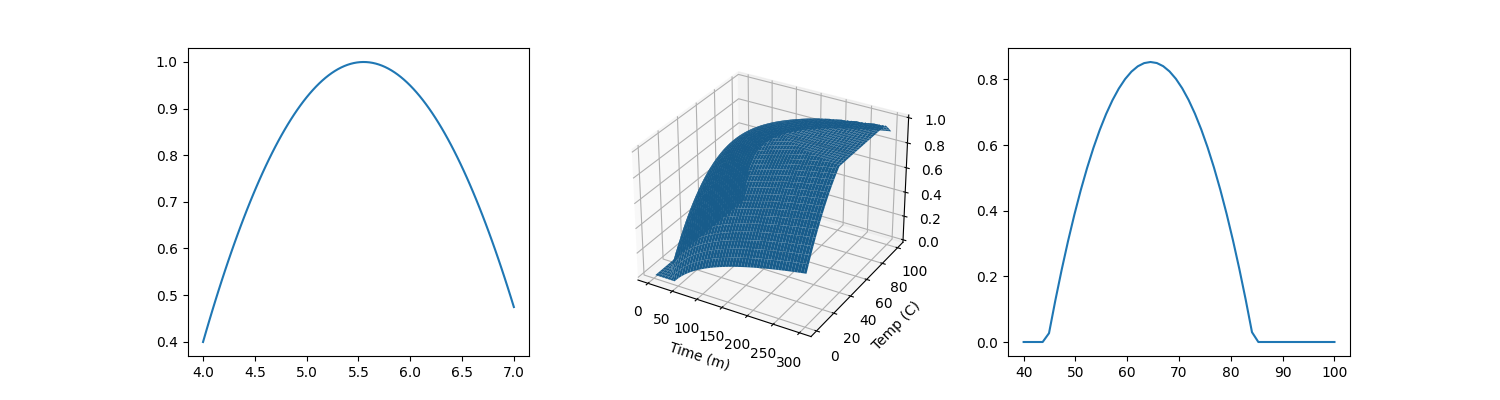

In [4]:
with torch.no_grad():
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1, 3, 1)
    x = torch.linspace(4, 7, 100)
    ax1.plot(x.cpu().numpy(), ph_atten_pct(x).cpu().numpy());
    
    times = torch.linspace(1, 300, 300)
    temps = torch.linspace(1, 100, 120)
    time, temp = torch.meshgrid(times, temps, indexing='xy')
    max_atten  = mash_eff_time_temp(time, temp)
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.set_xlabel("Time (m)")
    ax2.set_ylabel("Temp (C)")
    ax2.plot_surface(time.numpy(), temp.numpy(), max_atten.numpy());
    
    temps = torch.linspace(40, 100, 50)
    ax3 = fig.add_subplot(1,3,3)
    ax3.plot(temps.numpy(), mash_temp_to_atten(temps).numpy());

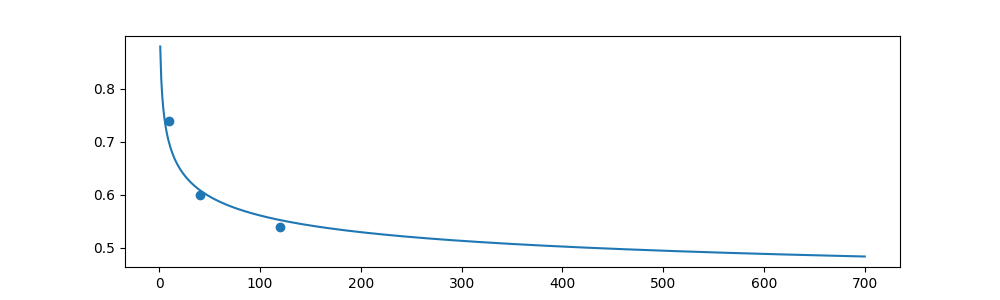

In [5]:
# Specialty Malt Fermentability (based on Lovibond)
# http://www.woodlandbrew.com/2012/12/fermentability-of-crystal-malt.html
# If we assume that the 2-row ferments the same regardless of being mashed with the crystal the 100% crystal fermentability numbers can be derived.
# 74% for C10
# 60% for C40
# 54% for C120
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(1, 1, 1)

lovibonds = torch.tensor([10,40,120])
ax1.scatter(lovibonds.cpu().numpy(), [0.74,0.6,0.54])

# Determine the rough fermentability of a specilty malt (Crystal and Roasted) based on its Lovibond
# IMPORTANT: This ASSUMES that there is a high enough Diastatic Power in the Mash (based on ~ >=50% 2-Row malt bills)
def lovibond_fermentability(lovibond):
    return -0.09*(lovibond.log()) * (1 - 0.05*lovibond.log()) + 0.88

x = torch.linspace(1,700,700)
ax1.plot(x.cpu().numpy(), lovibond_fermentability(x).cpu().numpy());